# Imports & Config

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!pip install gsutil mne

In [ ]:
!gsutil -m cp -r gs://eegmmidb-1.0.0.physionet.org ./

Copying gs://eegmmidb-1.0.0.physionet.org/64_channel_sharbrough-old.png...
Copying gs://eegmmidb-1.0.0.physionet.org/64_channel_sharbrough.pdf...
Copying gs://eegmmidb-1.0.0.physionet.org/ANNOTATORS...
Copying gs://eegmmidb-1.0.0.physionet.org/64_channel_sharbrough.png...
Copying gs://eegmmidb-1.0.0.physionet.org/RECORDS...
Copying gs://eegmmidb-1.0.0.physionet.org/eeg-motor-movementimagery-dataset-1.0.0.zip...
Copying gs://eegmmidb-1.0.0.physionet.org/wfdbcal...
Copying gs://eegmmidb-1.0.0.physionet.org/SHA256SUMS.txt...
Copying gs://eegmmidb-1.0.0.physionet.org/S001/S001R01.edf.event...
Copying gs://eegmmidb-1.0.0.physionet.org/S001/S001R01.edf...
Copying gs://eegmmidb-1.0.0.physionet.org/S001/S001R02.edf...
Copying gs://eegmmidb-1.0.0.physionet.org/S001/S001R02.edf.event...
Copying gs://eegmmidb-1.0.0.physionet.org/S001/S001R03.edf.event...
Copying gs://eegmmidb-1.0.0.physionet.org/S001/S001R03.edf...
Copying gs://eegmmidb-1.0.0.physionet.org/S001/S001R05.edf...
Copying gs://eegmmid

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import tensorflow as tf
import os
import zipfile
import mne
import cv2
import imutils
import tensorflow as tf

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

from matplotlib.ticker import ScalarFormatter,AutoMinorLocator

from tensorflow.keras.layers import (
  Input, Dense, Multiply, Activation, Lambda, Reshape, BatchNormalization,
  LeakyReLU, Flatten, Dropout, Concatenate, Add,
  Conv2D, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D,
)
from tensorflow.keras.regularizers import l2, l1, l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import Sequence, plot_model

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from google.colab.patches import cv2_imshow
from itertools import combinations

In [ ]:
np.random.seed(0)

In [ ]:
plt.style.use('/content/fig.mplstyle')

In [ ]:
runs = [i for i in range(2, 15)]
eegbci.load_data(1, runs)

['/root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R02.edf',
 '/root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R03.edf',
 '/root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R04.edf',
 '/root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R05.edf',
 '/root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf',
 '/root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R07.edf',
 '/root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R08.edf',
 '/root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R09.edf',
 '/root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf',
 '/root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R11.edf',
 '/root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R12.edf',
 '/root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R13.edf',
 '/root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf']

In [ ]:
%mv eegmmidb-1.0.0.physionet.org ../../root/mne_data/MNE-eegbci-data/files/eegmmidb/

In [ ]:
%rm -rf ../../root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/

In [ ]:
%mv ../../root/mne_data/MNE-eegbci-data/files/eegmmidb/eegmmidb-1.0.0.physionet.org ../../root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0

In [ ]:
NFFT = 160
NOVERLAP = NFFT - 1
FS = 160
CMAP = "viridis"
FIGSIZE = (0.54, 0.36)
BATCH_SIZE = 16

# Dataset Loading

In [ ]:
def get_spectrogram(data, fs, nfft, noverlap, figsize, cmap):
  fig, ax = plt.subplots(1, figsize=figsize)
  fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
  fig.dpi = 100
  ax.axis('off')
  ax.grid(False)

  pxx, freqs, bins, im = ax.specgram(x=data, Fs=fs, noverlap=noverlap, NFFT=nfft, cmap=cmap)
  return fig2rgb(fig)

def fig2rgb(fig):
  fig.canvas.draw()
  buf = fig.canvas.tostring_rgb()
  width, height = fig.canvas.get_width_height()
  plt.close(fig)
  return np.frombuffer(buf, dtype=np.uint8).reshape(height, width, 3)

def rgb2gray(rgb_img):
  cv_rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2BGR)
  cv_gray = cv2.cvtColor(cv_rgb_img, cv2.COLOR_BGR2GRAY)
  return cv_gray

def min_max_scale(spectrogram, f_min, f_max):
  spec_std = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min())
  spec_scaled = spec_std * (f_max - f_min) + f_min
  return spec_scaled

In [ ]:
def build_dataset(start = 1, end = 20, channel_index = 0):
  dataset = {}

  tmin, tmax = -1., 17.
  event_id = dict(hands=2, feet=3)
  runs = [6, 10, 14]
  subjects = [i for i in range(start, end+1)]
  Y = []
  X = []
  if end > 87 :
    subjects.remove(88)
    subjects.remove(92)
    subjects.remove(100)
  count = 0

  for subject in subjects:
    raw_fnames = eegbci.load_data(subject, runs)
    raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
    eegbci.standardize(raw)
    montage = make_standard_montage('standard_1005')
    raw.set_montage(montage)

    # strip channel names of "." characters
    raw.rename_channels(lambda x: x.strip('.'))

    # Apply band-pass filter
    raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')

    events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))

    picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')

    epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks, baseline=None, preload=True)
    epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
    labels = epochs.events[:, -1] - 2
    x = np.array((epochs.get_data(picks='eeg')[:, channel_index, :]), dtype=np.float)
    
    for k in range(x.shape[0]):
      signal = x[k]
      
      norm_signal = min_max_scale(signal, 0.0, 1.0)

      X.append(norm_signal)
      Y.append(count)
    count += 1

  dataset['x'] = np.array(X)
  dataset['y'] = np.array(Y)
  return dataset

In [ ]:
train_dataset = build_dataset(start=1,end=3, channel_index=63)
# test_dataset = build_dataset(start=81,end=109, channel_index=63)

Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passb

In [ ]:
print(train_dataset["x"].shape, train_dataset["x"].dtype, train_dataset["y"].shape, train_dataset["y"].dtype)
print(train_dataset["x"].max(), train_dataset["x"].min(), train_dataset["x"].mean(), train_dataset["x"].std())

# print(test_dataset["x"].shape, test_dataset["x"].dtype, test_dataset["y"].shape, test_dataset["y"].dtype)
# print(test_dataset["x"].max(), test_dataset["x"].min(), test_dataset["x"].mean(), test_dataset["x"].std())

(117, 2881) float64 (117,) int64
1.0 0.0 0.4336913308781996 0.13143799636150033


In [ ]:
x_train = train_dataset["x"]
y_train = train_dataset["y"]

# x_test = test_dataset["x"]
# y_test = test_dataset["y"]

0.0


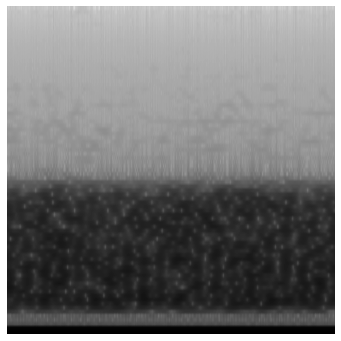

In [ ]:
def get_spectrogram(data, fs, nfft, noverlap, cmap):
  fig, ax = plt.subplots(figsize=(5,5))
  pxx, freqs, bins, im = ax.specgram(x=data, Fs=fs, noverlap=noverlap, NFFT=nfft, cmap=cmap)

  plt.ylabel('Frequency (Hz)')
  plt.xlabel('Time (s)')
  # plt.colorbar(im)

  ax.yaxis.set_major_formatter(ScalarFormatter())
  ax.yaxis.major.formatter._useMathText = True
  ax.axis('off')
  ax.grid(False)

  plt.savefig('/content/spectrogram-ar.png', dpi=300, transparent=False, bbox="tight")
  plt.show()

get_spectrogram(min_max_scale(x_train[1,:], 0.0, 1.0), FS, NFFT, NOVERLAP, "Greys")

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(2)
train_proj = pca.fit_transform(x_train)

In [ ]:
test_proj = pca.fit_transform(x_test)

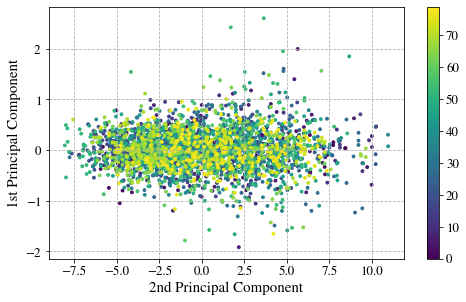

In [ ]:
fig, ax = plt.subplots()

plt.scatter(train_proj[:, 0], train_proj[:, 1],c=y_train[:], s=8, cmap='viridis')
plt.ylabel('1st Principal Component')
plt.xlabel('2nd Principal Component')
plt.colorbar()

ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.major.formatter._useMathText = True
# ax.legend(frameon=True, loc='best',ncol=1, handlelength=2, framealpha=1, edgecolor="0.8", fancybox=False)
plt.grid(True, ls="--", lw=0.8)

plt.savefig('/content/train_pca.png', dpi=300, transparent=False, bbox="tight")
plt.show()

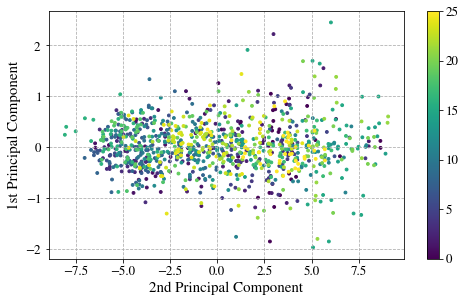

In [ ]:
fig, ax = plt.subplots()

plt.scatter(test_proj[:, 0], test_proj[:, 1],c=y_test[:], s=8, cmap='viridis')
plt.ylabel('1st Principal Component')
plt.xlabel('2nd Principal Component')
plt.colorbar()

ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.major.formatter._useMathText = True
# ax.legend(frameon=True, loc='best',ncol=1, handlelength=2, framealpha=1, edgecolor="0.8", fancybox=False)
plt.grid(True, ls="--", lw=0.8)

plt.savefig('/content/test_pca.png', dpi=300, transparent=False, bbox="tight")
plt.show()